In [1]:
import torch
import torch.nn.functional as F

torch.manual_seed(1)

In [2]:
## 소프트맥스의 비용함수 구현 : low-level

z=torch.FloatTensor([1,2,3])

hypothesis=F.softmax(z, dim=0)
print(hypothesis)

tensor([0.0900, 0.2447, 0.6652])


In [3]:
hypothesis.sum()

tensor(1.)

In [4]:
z=torch.rand(3,5,requires_grad=True)

In [5]:
hypothesis=F.softmax(z,dim=1)
print(hypothesis)

tensor([[0.2645, 0.1639, 0.1855, 0.2585, 0.1277],
        [0.2430, 0.1624, 0.2322, 0.1930, 0.1694],
        [0.2226, 0.1986, 0.2326, 0.1594, 0.1868]], grad_fn=<SoftmaxBackward0>)


In [6]:
hypothesis.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)

In [7]:
# 정답 레이블

y=torch.randint(5,(3,)).long()
print(y)

tensor([0, 2, 1])


In [8]:
y_one_hot=torch.zeros_like(hypothesis)
y_one_hot.scatter_(1,y.unsqueeze(1),1)

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [9]:
y_one_hot

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [10]:
cost=(y_one_hot*-torch.log(hypothesis)).sum(dim=1).mean()
print(cost)

tensor(1.4689, grad_fn=<MeanBackward0>)


In [11]:
## 파이토치로 소프트맥스의 비용함수 구현 : high-level
# F.softmax()+torch.log()=F.log_softmax()
torch.log(F.softmax(z,dim=1))

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]], grad_fn=<LogBackward0>)

In [12]:
F.log_softmax(z, dim=1)

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]],
       grad_fn=<LogSoftmaxBackward0>)

In [13]:
# F.log_softmax+F.nll_loss()=F.cross_entropy
(y_one_hot*-torch.log(F.softmax(z, dim=1))).sum(dim=1).mean()

tensor(1.4689, grad_fn=<MeanBackward0>)

In [14]:
(y_one_hot*-F.log_softmax(z, dim=1)).sum(dim=1).mean()

tensor(1.4689, grad_fn=<MeanBackward0>)

In [15]:
F.nll_loss(F.log_softmax(z,dim=1),y)

tensor(1.4689, grad_fn=<NllLossBackward0>)

In [16]:
# F.cross_entropy는 비용함수부터 소프트맥스 함수까지 포함하고 있다.
F.cross_entropy(z,y)

tensor(1.4689, grad_fn=<NllLossBackward0>)

In [17]:
## 소프트 맥스 회귀 구현하기 : low-level

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

In [18]:
print(x_train.shape)
print(y_train.shape)

torch.Size([8, 4])
torch.Size([8])


In [19]:
y_one_hot=torch.zeros(8,3)
y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)
print(y_one_hot)

tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])


In [20]:
W=torch.zeros((4,3),requires_grad=True)
b=torch.zeros(1, requires_grad=True)
optimizer=optim.SGD([W,b],lr=0.1)
epochs=1000

for epoch in range(epochs+1):
  hypothesis=F.softmax(x_train.matmul(W)+b, dim=1)
  cost=(y_one_hot*-torch.log(hypothesis)).sum(dim=1).mean()

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  if epoch%100==0:
    print(f"Epoch {epoch:4d}/{epochs} Cost : {cost.item():.6f}")

Epoch    0/1000 Cost : 1.098612
Epoch  100/1000 Cost : 0.761050
Epoch  200/1000 Cost : 0.689991
Epoch  300/1000 Cost : 0.643229
Epoch  400/1000 Cost : 0.604117
Epoch  500/1000 Cost : 0.568255
Epoch  600/1000 Cost : 0.533922
Epoch  700/1000 Cost : 0.500291
Epoch  800/1000 Cost : 0.466908
Epoch  900/1000 Cost : 0.433507
Epoch 1000/1000 Cost : 0.399962


In [21]:
## 소프트 맥스 회귀 구현하기 : high-level

W=torch.zeros((4,3),requires_grad=True)
b=torch.zeros(1, requires_grad=True)
optimizer=optim.SGD([W,b],lr=0.1)
epochs=1000

for epoch in range(epochs+1):
  z=x_train.matmul(W)+b
  cost=F.cross_entropy(z, y_train)

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  if epoch%100==0:
    print(f"Epoch {epoch:4d}/{epochs} Cost : {cost.item():.6f}")

Epoch    0/1000 Cost : 1.098612
Epoch  100/1000 Cost : 0.761050
Epoch  200/1000 Cost : 0.689991
Epoch  300/1000 Cost : 0.643229
Epoch  400/1000 Cost : 0.604117
Epoch  500/1000 Cost : 0.568256
Epoch  600/1000 Cost : 0.533922
Epoch  700/1000 Cost : 0.500291
Epoch  800/1000 Cost : 0.466908
Epoch  900/1000 Cost : 0.433507
Epoch 1000/1000 Cost : 0.399962


In [22]:
## Softmax 회귀 : nn.Module
model=nn.Linear(4,3)
optimizer=optim.SGD(model.parameters(),lr=0.1)
epochs=1000

for epoch in range(epochs):
  prediction=model(x_train)
  cost=F.cross_entropy(prediction, y_train)

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  if epoch%100==0:
    print(f"Epoch {epoch:4d}/{epochs} Cost : {cost.item():.6f}")

Epoch    0/1000 Cost : 1.849513
Epoch  100/1000 Cost : 0.689894
Epoch  200/1000 Cost : 0.609259
Epoch  300/1000 Cost : 0.551218
Epoch  400/1000 Cost : 0.500141
Epoch  500/1000 Cost : 0.451947
Epoch  600/1000 Cost : 0.405051
Epoch  700/1000 Cost : 0.358733
Epoch  800/1000 Cost : 0.312912
Epoch  900/1000 Cost : 0.269522


In [23]:
## Softmax 구현 : 회귀 클래스

class SoftmaxClassifierModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear=nn.Linear(4,3)

  def forward(self,x):
    return self.linear(x)

model=SoftmaxClassifierModel()
optimizer=optim.SGD(model.parameters(),lr=0.1)
epochs=1000

for epoch in range(epochs+1):
  prediction=model(x_train)
  cost=F.cross_entropy(prediction, y_train)

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  if epoch%100==0:
    print(f"Epoch {epoch:4d}/{epochs} Cost : {cost.item():.6f}")

Epoch    0/1000 Cost : 1.845720
Epoch  100/1000 Cost : 0.647150
Epoch  200/1000 Cost : 0.568868
Epoch  300/1000 Cost : 0.515699
Epoch  400/1000 Cost : 0.471727
Epoch  500/1000 Cost : 0.432486
Epoch  600/1000 Cost : 0.395880
Epoch  700/1000 Cost : 0.360507
Epoch  800/1000 Cost : 0.325227
Epoch  900/1000 Cost : 0.289217
Epoch 1000/1000 Cost : 0.254086


In [24]:
## Softmax 회귀로 MNIST 데이터 분류하기

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

USE_CUDA=torch.cuda.is_available()
device=torch.device("cuda" if USE_CUDA else "cpu")
print('다음 기기로 학습합니다. :',device)

다음 기기로 학습합니다. : cuda


In [25]:
random.seed(777)
torch.manual_seed(777)
if device=='cuda':
  torch.cuda.manual_seed_all(777)

In [26]:
training_epochs=15
batch_size=100

In [27]:
mnist_train=dsets.MNIST(root="MNIST_data/", train=True, transform=transforms.ToTensor(), download=True)

In [28]:
data_loader=DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)

In [29]:
linear=nn.Linear(784,10, bias=True).to(device)

In [30]:
criterion=nn.CrossEntropyLoss().to(device) # 내부적으로 소프트 맥스 함수를 포함
optimizer=torch.optim.SGD(linear.parameters(), lr=0.1)

In [31]:
for epoch in range(training_epochs):
  avg_cost=0
  total_batch=len(data_loader)

  for X, Y in data_loader:
    X=X.view(-1,28*28).to(device)
    Y=Y.to(device)
    
    hypothesis=linear(X)
    cost=criterion(hypothesis, Y)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    avg_cost+=cost/total_batch
  
  print("Epoch :","%04d"%(epoch+1),"cost =",f"{avg_cost:.9f}")

print('Learning Finished')

Epoch : 0001 cost = 0.535150647
Epoch : 0002 cost = 0.359577745
Epoch : 0003 cost = 0.331264257
Epoch : 0004 cost = 0.316404670
Epoch : 0005 cost = 0.307106972
Epoch : 0006 cost = 0.300456583
Epoch : 0007 cost = 0.294933438
Epoch : 0008 cost = 0.290956229
Epoch : 0009 cost = 0.287074089
Epoch : 0010 cost = 0.284515619
Epoch : 0011 cost = 0.281914085
Epoch : 0012 cost = 0.279526889
Epoch : 0013 cost = 0.277636617
Epoch : 0014 cost = 0.275874794
Epoch : 0015 cost = 0.274422735
Learning Finished


In [32]:
mnist_test=dsets.MNIST(root="MNIST_data/", transform=transforms.ToTensor(), train=False, download=True)

Accuacy : 0.8883000016212463
Label: 8
Prediction : 3


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


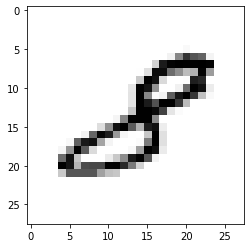

In [33]:
# 테스트 데이터 사용



with torch.no_grad():
  X_test=mnist_test.test_data.view(-1,28*28).float().to(device)
  Y_test=mnist_test.test_labels.to(device)

  prediction=linear(X_test)
  correct_prediction=torch.argmax(prediction,1)==Y_test
  accuracy=correct_prediction.float().mean()
  print('Accuacy :',accuracy.item())

  r=random.randint(0,len(mnist_test)-1)
  X_single_data=mnist_test.test_data[r].view(-1,28*28).float().to(device)
  Y_single_data=mnist_test.test_labels[r].to(device)

  print("Label:", Y_single_data.item())
  single_prediction=linear(X_single_data)
  print("Prediction :",torch.argmax(single_prediction,1).item())

  plt.imshow(mnist_test.test_data[r].view(28,28), cmap="Greys",interpolation="nearest")
  plt.show()